# Hands On

## Get data

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

## Load data

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

## Make income category to stratify on

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64


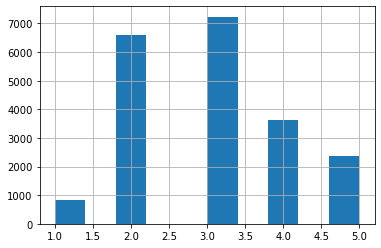

In [5]:
import numpy as np
bins = [0.0,1.5,3.0,4.5,6.0,np.inf]
labels = [1,2,3,4,5]

housing["income_cat"] = pd.cut(housing["median_income"],bins=bins,labels=labels)
print(housing["income_cat"].value_counts())
housing["income_cat"].hist()

## Split and stratify data

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

## Make processing pipeline
Numerical and categorical data

In [7]:
housing = strat_train_set.drop(["median_house_value","income_cat"], axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)

In [8]:
len(housing.columns)

9

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])


## Run pipeline

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [12]:
housing_prepared.shape

(16512, 16)

## Question 1

**Try a support vector machine regressor with various linear, rbf, C, and gamma parameters. How does the best SVR perform compared to the random forest regressor?**

Compared to the random forest regressor (mse = ~50000), the SVR performs worse.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

# run time is 30 minutes
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
import numpy as np
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(grid_search.best_params_)

## Question 2

**Replace GridSearchCV with RandomizedSearchCV. Compare results to GridSearch and random forest regressor.**

Compared to the random forest regressor (mse = ~50000), the SVR with a random search is equivalent. The randomized parameter search provided better parameters and lower mse than the grid search. However, the training time higher at ~45 minutes. 

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR

params = {
    "kernel":["linear","rbf"],
    "C":reciprocal(20,200000),
    "gamma":expon(scale=1.0)
}

svm_reg = SVR()
rand_search_svr = RandomizedSearchCV(svm_reg, param_distributions=params, 
                                 n_iter=10, cv=5, 
                                 scoring="neg_mean_squared_error",
                                 verbose=1, random_state=42
)

rand_search_svr.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.2min finished


RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f149a3678b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f149a53a430>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [41]:
import numpy as np
negative_mse = rand_search_svr.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(rand_search_svr.best_params_)

54767.960710084146
{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}


**Examine range of parameters from epxonential and reciprocal distirbution**

Exponential is useful in grid search for when you have a basic idea of what the target scale should be. Reciprocal is useful when you have no idea what the scale of a hyperparameter should be. 

In [ ]:
import matplotlib.pyplot as plt 
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

## Question 3

**Add a transformer to the preparation pipeline to select only the most important attributes.**

**Find feature importances with random forest regressor.**

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42
)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f149a3497f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f14996f86d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [23]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.24699052e-02, 6.38080322e-02, 4.27504395e-02, 1.65343807e-02,
       1.56100762e-02, 1.60929106e-02, 1.52149598e-02, 3.45178404e-01,
       5.74445360e-02, 1.08468449e-01, 7.05907498e-02, 8.77441303e-03,
       1.60563229e-01, 6.10403994e-05, 3.08961266e-03, 3.34886200e-03])

In [24]:
# gather up the feature names. remember that the processed training set is a array without headers.
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3451784043801197, 'median_income'),
 (0.1605632289158767, 'INLAND'),
 (0.10846844860879654, 'pop_per_hhold'),
 (0.07246990515559049, 'longitude'),
 (0.07059074984842853, 'bedrooms_per_room'),
 (0.06380803224443841, 'latitude'),
 (0.057444535971841064, 'rooms_per_hhold'),
 (0.04275043945662488, 'housing_median_age'),
 (0.01653438073955306, 'total_rooms'),
 (0.016092910597195798, 'population'),
 (0.015610076150868492, 'total_bedrooms'),
 (0.015214959838627942, 'households'),
 (0.008774413032023276, '<1H OCEAN'),
 (0.003348861998751043, 'NEAR OCEAN'),
 (0.0030896126618977565, 'NEAR BAY'),
 (6.104039936629334e-05, 'ISLAND')]

**Build a feature selector class for the pipeline**

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

**Find the indices of the top features we want to select.** 

In [26]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [27]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [28]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3451784043801197, 'median_income'),
 (0.1605632289158767, 'INLAND'),
 (0.10846844860879654, 'pop_per_hhold'),
 (0.07246990515559049, 'longitude'),
 (0.07059074984842853, 'bedrooms_per_room')]

**Assemble processing and selection pipeline.**

In [29]:
prep_and_feature_select_pipeline = Pipeline([
    ("preparation",full_pipeline),
    ("feature_selection",TopFeatureSelector(feature_importances, k))
])

housing_preped_top_k_features = prep_and_feature_select_pipeline.fit_transform(housing)

**Confirm that top k features are align.**

In [30]:
housing_preped_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

In [31]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

## Question 4

**Try creating a single pipelinefeature_importancesoes the full data preparation plus final prediction.**

After running random search for the SVR, use the best parameters.

In [42]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rand_search_svr.best_params_))
])

In [43]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

**Run the pipeline on a few instances**

In [44]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [185384.13066634 341000.56131537 172531.39955817  56040.55006167]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


## Question 5

**Automatically explore preparation options with GridSearchCV**

Basically prepend additional processing tests to the front of the pipeline. Not much is gained from this step. The output implies that all features are important at this phase. Regardless, it demonstrates another way to search for best methods when building a full machine learning pipeline.

In summary, this notebook demonstrates the ability to "automate" the entire machine learning pipeline. From processing through model training and prediction. At this point the entire notebook could be converted to a streamlined set of scripts to the entire operation.

Note: Why does the below grid run with so many iterations? 

In [45]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   5.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 43.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [46]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}